## Santander Customer Transactions predictions

#BigDataSets#RandomForest#GrqdientBoosting#HighDimensionality#DataBalancing

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import gc
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler

import joblib

In [10]:
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

the submission contains the forecasted prices, then I merge the submission and the Test set

In [11]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
#test = test.merge(ss, left_on = 'ID_code', right_on = 'ID_code', how = 'inner')

In [12]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

#### Measuring null data

Droping those that have high number of empty rows

In [5]:
def nullcalc(df,variable):
    nulls = len(df[df[variable].isna()])
    rows = len(df)
    value = round(len(df[df[variable].isna()])/len(train)*100,2)
    string =  'The column ' + variable + ' has ' + str(value) + '% of nulls'
    return string,value

In [6]:
for variable in train.columns:
    if nullcalc(train,variable)[1] > 0 :
        print(nullcalc(train,variable)[0])

seems that data is 100% complete so no nulls

<b> More Exploration

Target

In [7]:
df = train.pivot_table(index = 'target', aggfunc = 'count')[['ID_code']].reset_index()
df['total'] = df.ID_code.sum()
df = df.assign(percent = df.ID_code/df.total)

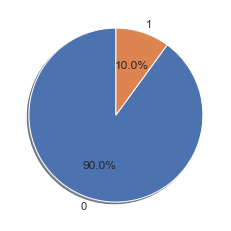

In [8]:
fig1, ax1 = plt.subplots()
ax1.pie(df.percent, labels = df.target , autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

Target will need balance

<b> variable by variable

In [9]:
def plotviolins(ini):
    fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
    varsuse = 5
    rows = [0,0,0,0,0,1,1,1,1,1]
    cols =[0,1,2,3,4,0,1,2,3,4]
    ini = ini

    for row,col in zip(rows,cols):

        end = ini + varsuse
        columns = list(train.columns[ini:end])
        df = train[columns + ['target'] ].melt(id_vars=['target'], value_vars = columns, var_name='Var', value_name='Value')
        sns.violinplot(ax = axs[row,col], data=df, x="Var", y="Value", hue="target",split=True, inner="quart", linewidth=1,scale="count")

        ini = end

    return plt.show()

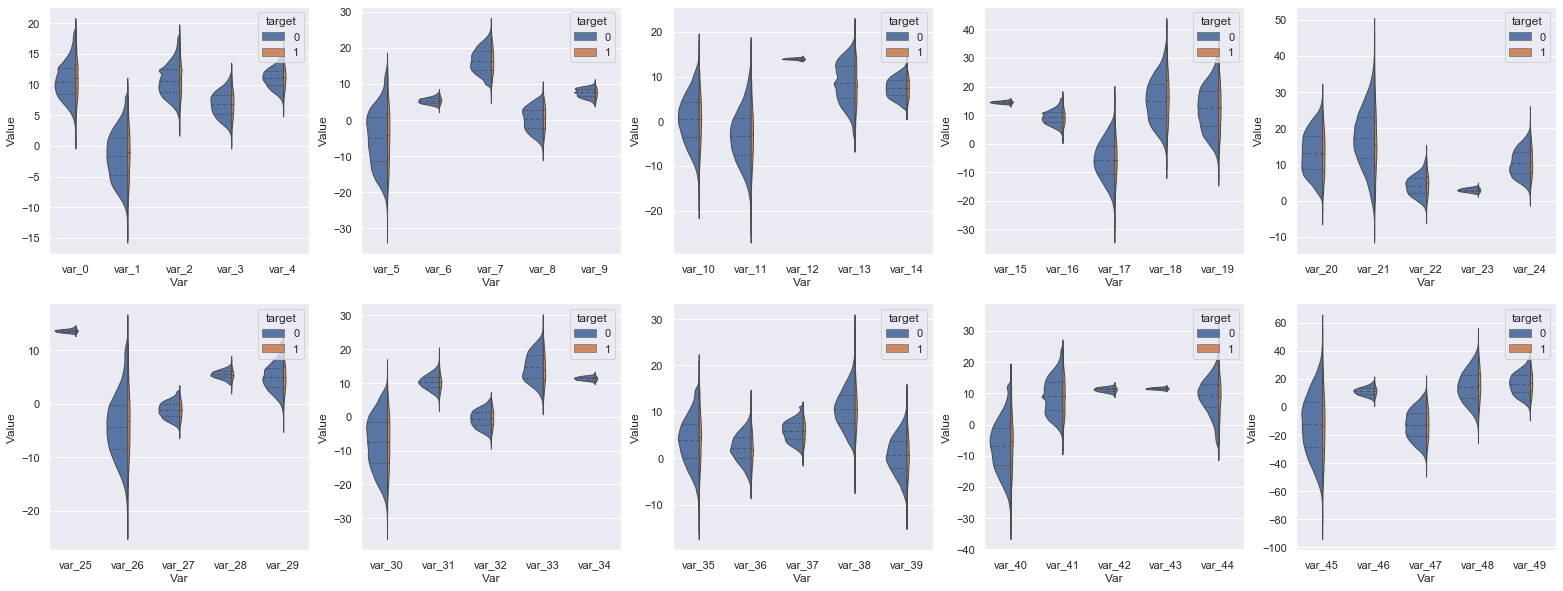

In [10]:
plotviolins(ini = 2)

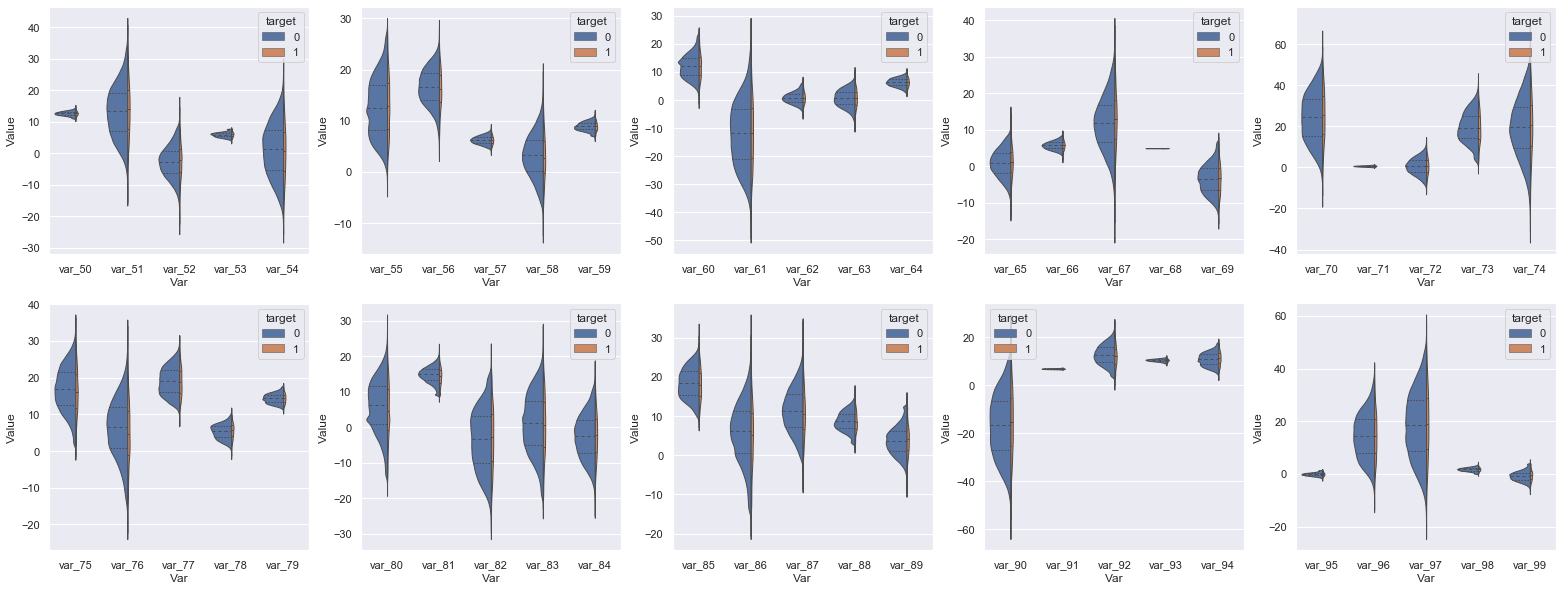

In [11]:
plotviolins(ini = 52)

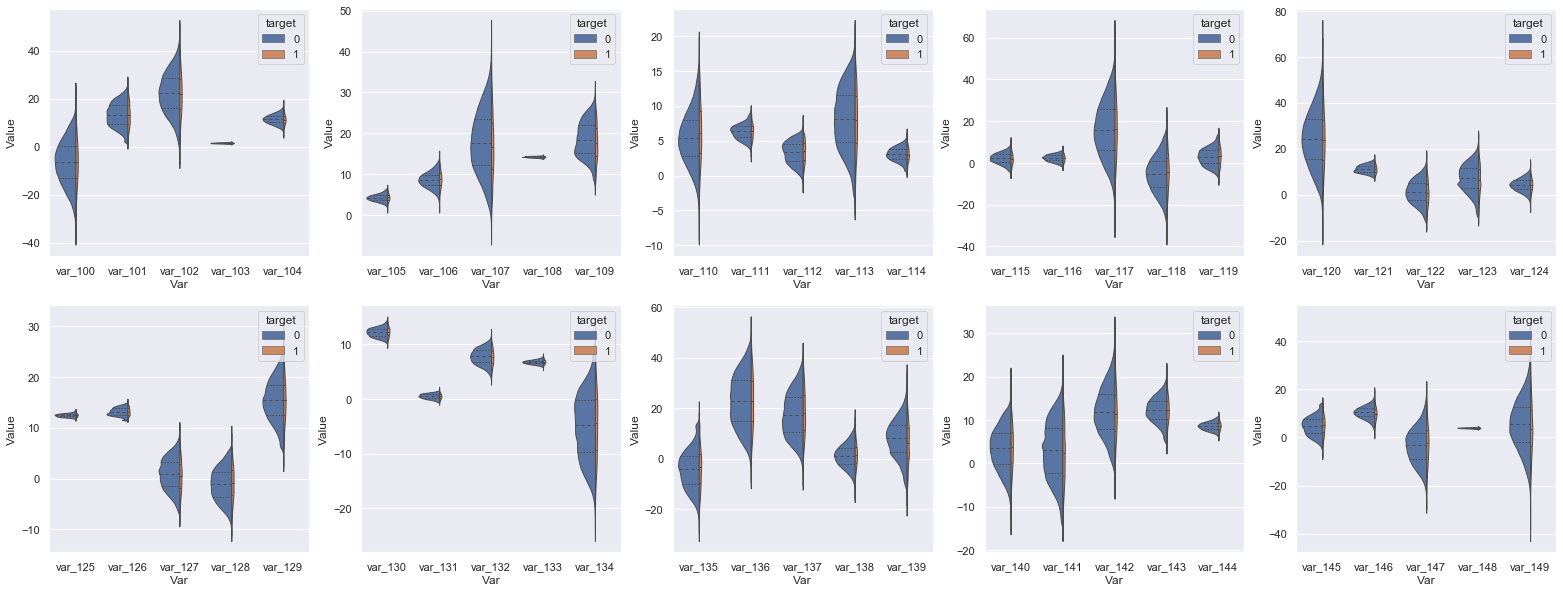

In [12]:
plotviolins(ini = 102)

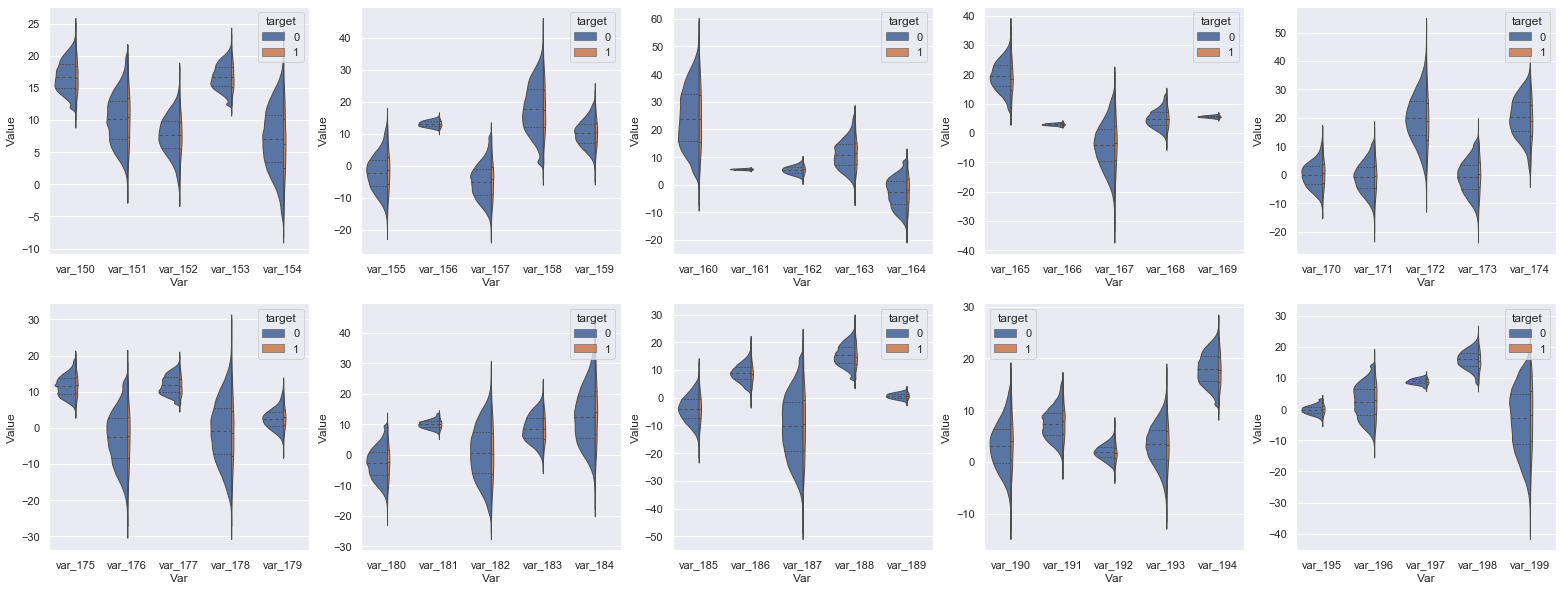

In [13]:
plotviolins(ini = 152)

interesting the distribution of all the variables

### Feature analysis

In [14]:
correlations = train.iloc[:,2::].corr()

finding high correlations

In [15]:
correlations

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
var_0    1.000000 -0.000544  0.006573  0.003801  0.001326  0.003046  0.006983   
var_1   -0.000544  1.000000  0.003980  0.000010  0.000303 -0.000902  0.003258   
var_2    0.006573  0.003980  1.000000  0.001001  0.000723  0.001569  0.000883   
var_3    0.003801  0.000010  0.001001  1.000000 -0.000322  0.003253 -0.000774   
var_4    0.001326  0.000303  0.000723 -0.000322  1.000000 -0.001368  0.000049   
...           ...       ...       ...       ...       ...       ...       ...   
var_195  0.002073 -0.000785 -0.001070  0.001206  0.003706 -0.001274  0.001244   
var_196  0.004386 -0.000377  0.003952 -0.002800  0.000513  0.002880  0.005378   
var_197 -0.000753 -0.004157  0.001078  0.001164 -0.000046 -0.000535 -0.003565   
var_198 -0.005776 -0.004861 -0.000877 -0.001651 -0.001821 -0.000953 -0.003025   
var_199  0.003850  0.002287  0.003855  0.000506 -0.000786  0.002767  0.006096   

            var_7     var_8     var_9  ...   var_190   var_191   var_192  \
var_0    0.002429  0.004962 -0.002613  ...  0.002752  0.000206 -0.005373   
var_1    0.001511  0.004098 -0.000832  ...  0.006627  0.003621 -0.002604   
var_2   -0.000991  0.002648 -0.001932  ...  0.000197  0.001285 -0.003400   
var_3    0.002500  0.003553 -0.000826  ...  0.000151  0.002445 -0.001530   
var_4    0.004549  0.001194 -0.000918  ...  0.001514  0.004357  0.003347   
...           ...       ...       ...  ...       ...       ...       ...   
var_195  0.001854  0.001396 -0.000868  ...  0.004571  0.000870 -0.004745   
var_196  0.001045 -0.003242  0.000052  ... -0.000847  0.002466 -0.001386   
var_197  0.003466 -0.004583  0.003701  ... -0.004974  0.000906 -0.000527   
var_198  0.000650  0.002950  0.002343  ... -0.000153 -0.000067  0.003451   
var_199 -0.001457  0.000854  0.001070  ... -0.000404  0.003595 -0.001239   

          var_193   var_194   var_195   var_196   var_197   var_198   var_199  
var_0    0.001616 -0.001514  0.002073  0.004386 -0.000753 -0.005776  0.003850  
var_1    0.001153 -0.002557 -0.000785 -0.000377 -0.004157 -0.004861  0.002287  
var_2    0.000549  0.002104 -0.001070  0.003952  0.001078 -0.000877  0.003855  
var_3   -0.001699 -0.001054  0.001206 -0.002800  0.001164 -0.001651  0.000506  
var_4    0.000813 -0.000068  0.003706  0.000513 -0.000046 -0.001821 -0.000786  
...           ...       ...       ...       ...       ...       ...       ...  
var_195 -0.003143 -0.001201  1.000000  0.002517 -0.004170 -0.000536  0.002042  
var_196 -0.005308 -0.005040  0.002517  1.000000 -0.000454  0.000253  0.000607  
var_197  0.005068  0.000884 -0.004170 -0.000454  1.000000  0.001183  0.004991  
var_198  0.001646  0.003194 -0.000536  0.000253  0.001183  1.000000 -0.004731  
var_199 -0.000552 -0.005615  0.002042  0.000607  0.004991 -0.004731  1.000000  

[200 rows x 200 columns]

In [16]:
variables = list(correlations.columns)
cutoff = 0.5
for var in variables:
    index_1 = variables.index(var)+1
    therest = variables[index_1:]
    for nextvar in therest:
        corr = abs(correlations.loc[var,nextvar])
        if corr > cutoff:
            print(var,nextvar)

fuck no high correlated variables

#### More vizs

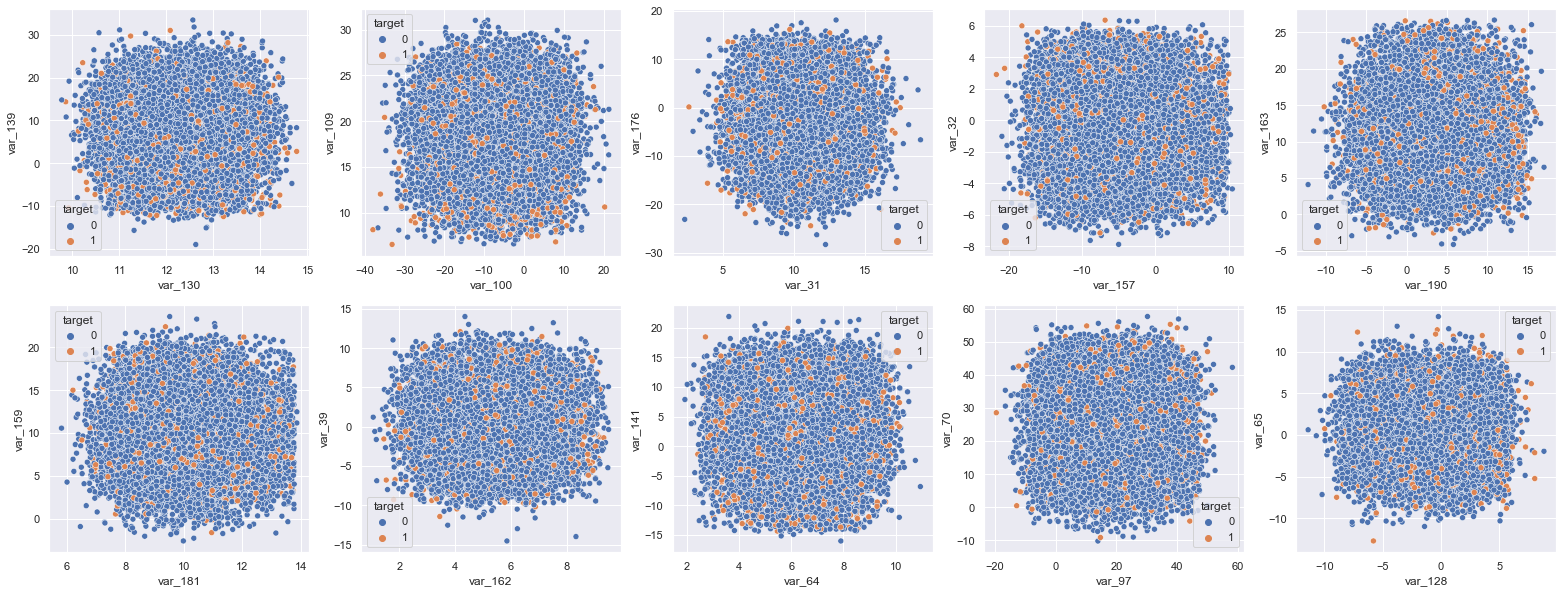

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
rows = [0,0,0,0,0,1,1,1,1,1]
cols =[0,1,2,3,4,0,1,2,3,4]

for row,col in zip(rows,cols):
    cols = list(range(2,199))
    rand = random.choice(cols)
    var1 =list(train.columns)[rand]
    rand = random.choice(cols)
    var2 = list(train.columns)[rand]
    df = train[['target',var1,var2]].sample(frac = 0.10, replace = False)
    sns.scatterplot(ax = axs[row,col],data=df, x=list(df.columns)[1], y=list(df.columns)[2], hue="target")
    
plt.show()

### Balancing DataSet

Goal to have 45% of 1 targuet,that is 95K new 1 targets

In [9]:
#quants have the interquantile ranges of the columns in their respective order
quants = []
for var in list(train.columns)[2:]:
    q1 = train[var].quantile(0.25)
    q3 = train[var].quantile(0.75)
    IQR = q3 - q1
    quants.append(IQR)

In [10]:
ones = train[train.target == 1].copy()
ones.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4    var_5  \
13  train_13       1  16.3699  1.5934  16.7395  7.3330  12.1450   5.9004   
29  train_29       1   5.3301 -2.6064  13.1913  3.1193   6.6483  -6.5659   
63  train_63       1   7.7072  0.0183   9.9974  8.3524   9.2886 -13.3627   
65  train_65       1  10.5358 -2.5439   8.7394  6.7548  14.4099  -3.8724   
71  train_71       1   6.7547  2.5973  14.2141  8.3514   7.4942  -1.3055   

     var_6    var_7  ...  var_190  var_191  var_192  var_193  var_194  \
13  4.8222  20.9729  ...   7.4002   7.4031   4.3989   4.0978  17.3638   
29  5.9064  15.2341  ...   5.9215   7.9676   2.3405   1.1482  23.2168   
63  6.0425  10.1108  ...   1.5832   5.0039   3.8814   7.4241  21.4844   
65  5.1584  15.8381  ...   4.6648   6.4227   3.4025  -4.0882  14.1174   
71  4.2336  15.0243  ...   1.4677   3.5935   2.0013   1.5777  18.2820   

    var_195  var_196  var_197  var_198  var_199  
13  -1.3022   9.6846   9.0419  15.6064 -10.8529  
29  -2.0105   3.7600   9.4513  17.4105 -14.6897  
63  -0.8297  -3.0468   7.5790  15.7685   5.4769  
65  -0.2472   5.3847   8.6949  15.1340   3.8449  
71  -4.3408   6.8869   9.3567  18.9013  13.3447  

[5 rows x 202 columns]

In [11]:
def symulationBalance(ones,newrowstogen):
    columns = list(ones.columns)

    features = list(ones.columns)[2:]
    orderquants = list(range(0,len(features)))

    beta = 0.04

    varx = [[] for x in range(200)]
    for i in range(newrowstogen):
        sampleexe = ones.sample(n = 1, replace = True)
        for var,order,x in zip(features,orderquants, range(len(features))):
            IQR = quants[0]
            space = np.random.uniform(-IQR*beta,IQR*beta,1)[0]
            value = sampleexe.loc[:,var].values[0]
            newValue = value + space
            
            varx[x].append(newValue)

        del sampleexe,  value, IQR, space, var
        
    dictionary = dict(zip(features, varx))
    newdata = pd.DataFrame.from_dict(dictionary)
    return newdata

In [15]:
%%time
dfstomerge = []
for x in range(10):
    exp = symulationBalance(ones = ones,newrowstogen = 10000)
    print(str(x) + 'is done')
    dfstomerge.append(exp)
    del exp
simulations = pd.concat(dfstomerge)

0is done
1is done
2is done
3is done
4is done
5is done
6is done
7is done
8is done
9is done
Wall time: 56min 32s


In [ ]:
simulations['ID_code'] = 'simu'
simulations['target'] = 1
simulationssave = simulations[['ID_code','target'] + list(simulations.columns)].copy()

In [ ]:
tosave = simulationssave.iloc[:,0:-2].reset_index(drop=True)
tosave.head(5)

ID_code  target      var_0     var_1      var_2     var_3      var_4  \
0    simu       1   8.268425  2.839179   9.847072  6.004561  10.595700   
1    simu       1  13.277118 -3.489872  12.391481  5.692317   8.532536   
2    simu       1   6.861841 -3.244343  10.605424  8.774338   8.806491   
3    simu       1   8.684302  7.856254  10.136461  7.563724  10.536348   
4    simu       1  11.304591  2.693123  11.359697  4.468651  10.235416   

       var_5     var_6      var_7  ...   var_190   var_191   var_192  \
0  -7.014598  4.858246  14.246894  ...  5.191049  8.898984  1.049433   
1   2.316671  5.635302  20.208096  ...  3.403580  8.804034  0.457999   
2  -9.582773  5.406340  12.759161  ...  8.062751  4.874438  0.466325   
3 -17.387639  5.826580  13.881966  ...  7.613764  9.108653  1.505509   
4  -6.959012  4.422405  18.001471  ... -5.191789  8.829335  2.761615   

    var_193    var_194   var_195   var_196   var_197    var_198    var_199  
0  7.280494  22.367514  2.875749 -1.087895  7.520943  10.650506   3.922899  
1  2.451355  14.009796  0.018513  0.418258  9.160833  16.853819   5.747460  
2  1.959918  19.599178  0.748316 -5.054202  6.904395   9.233359 -10.937007  
3  2.689764  24.837332 -1.939792  6.681305  9.280628  12.747434  -3.063499  
4  5.274571  16.587238 -1.161090  1.608989  9.072672  17.306502 -13.310816  

[5 rows x 202 columns]

In [ ]:
tosave.shape

(100000, 202)

In [19]:
#tosave.to_csv('simulations.csv',index = False)

<b> verifying the simulations

In [21]:
simulations = pd.read_csv('simulations.csv').sample(frac = 0.50, replace = False)
simulations.head()

ID_code  target      var_0     var_1      var_2      var_3      var_4  \
14556    simu       1  13.030271 -7.443940  14.084449   7.425765  13.135775   
15044    simu       1   9.080449 -2.426579   9.279717  12.083762   9.964316   
85396    simu       1   8.674405 -6.441518  10.772706   5.563931  12.304282   
31033    simu       1  15.847964  1.683477  13.574171   8.094981  14.379831   
65359    simu       1   8.446548 -5.191044  12.468304   6.595133  11.223841   

           var_5     var_6      var_7  ...   var_190   var_191   var_192  \
14556  -3.643425  5.271061  19.728724  ...  8.494164  9.139530  0.949476   
15044   1.090848  4.803097  15.039238  ...  9.771212  9.951894  0.844986   
85396 -18.812826  5.383377  20.695265  ...  8.825217  8.021147  2.321842   
31033   6.163924  4.821619  11.498825  ...  8.344622  8.190119  3.583237   
65359   5.506546  4.353787  17.975309  ... -1.976567  9.727050  1.023811   

        var_193    var_194   var_195   var_196   var_197    var_198    var_199  
14556  5.080632  20.024753 -1.431843 -4.911619  8.693262  13.998850  -0.913612  
15044 -4.741113  18.599197  1.602231 -4.191786  9.393216  14.078426 -14.612280  
85396 -0.342224  17.839276  0.953498 -1.703668  7.568424  13.372772   5.209161  
31033  2.474561  19.529034  0.781609  6.300373  9.853798  13.290147  18.533074  
65359  5.040886  19.314013 -2.698129 -5.831436  8.370007  18.798626  -3.707838  

[5 rows x 202 columns]

In [22]:
simulations.shape

(50000, 202)

In [23]:
train['TypeSet'] = 'Original'
simulations['TypeSet'] = 'Augmented'
balancedtrain = pd.concat([train,simulations])

In [12]:
df = balancedtrain.pivot_table(index = 'target', aggfunc = 'count')[['ID_code']].reset_index()
df['total'] = df.ID_code.sum()
df = df.assign(percent = df.ID_code/df.total)

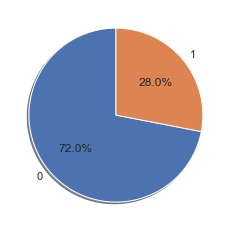

In [13]:
fig1, ax1 = plt.subplots()
ax1.pie(df.percent, labels = df.target , autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

Seems a good balance in order to not loose to loose just some accuracy on the predictors (gain some bias)

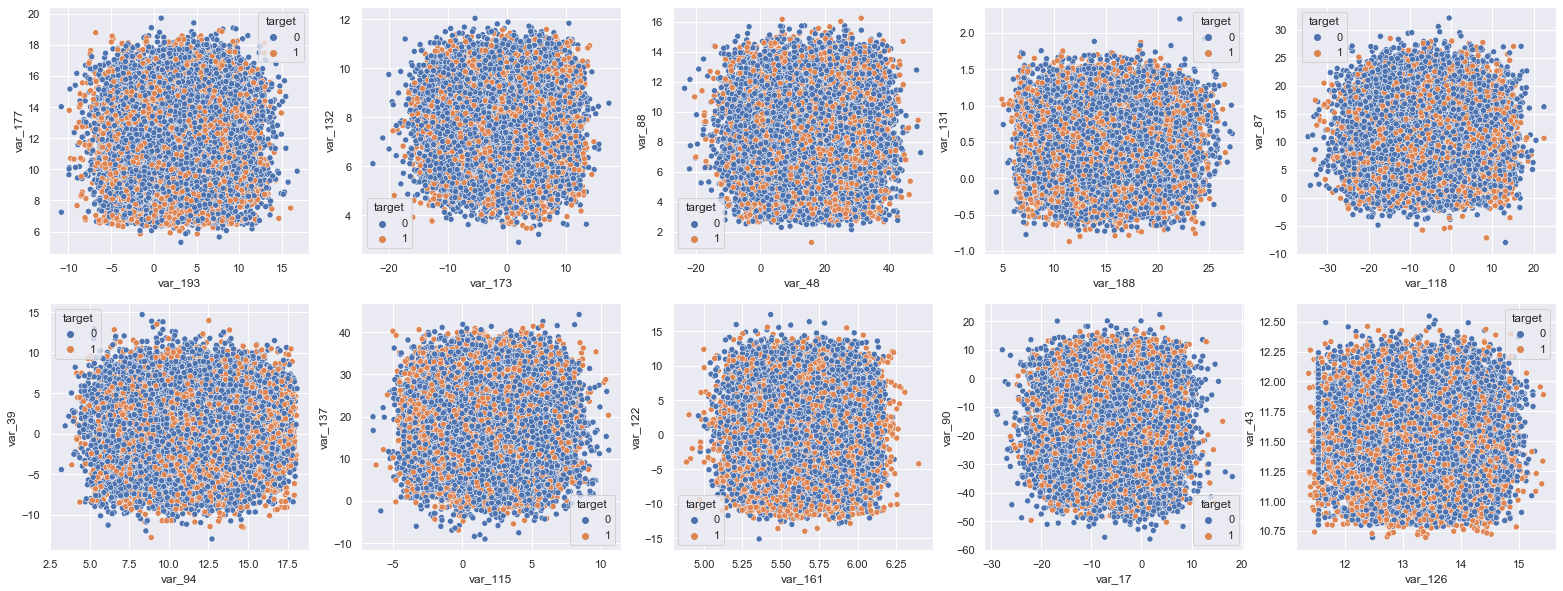

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
rows = [0,0,0,0,0,1,1,1,1,1]
cols =[0,1,2,3,4,0,1,2,3,4]
columns = list(train.columns)[0:-1]
for row,col in zip(rows,cols):
    cols = list(range(2,199))
    rand = random.choice(cols)
    var1 = columns[rand]
    rand = random.choice(cols)
    var2 = columns[rand]
    df = balancedtrain[['target',var1,var2]].sample(frac = 0.10, replace = False)
    sns.scatterplot(ax = axs[row,col],data=df, x=list(df.columns)[1], y=list(df.columns)[2], hue="target")
    
plt.show()

Eventhough the balancing stressed the True data to redict, The blue points, False, Have strong influence or are quite near from the orange zones
One strategy is smart data reduction using distince measures to drop data on the zones where is high true density data

The data reduction is made over the train set

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

In [35]:
trainTB = train.drop(columns = 'TypeSet').copy().sample(n = 70000, replace = False)
trainTB['targetNew'] = trainTB['target']
trainTB['distance'] = 0
columns_gen = ['var_0','var_2','var_6', 'var_12', 'var_21', 'var_22', 'var_26', 'var_44', 'var_53', 'var_68', 'var_76', 'var_80', 'var_81', 'var_91',
 'var_99','var_108', 'var_109', 'var_110', 'var_139', 'var_146', 'var_148','var_165', 'var_166', 'var_174','var_190']

MMscaler = MinMaxScaler((0,10))
trainTB[columns_gen] = MMscaler.fit_transform(trainTB[columns_gen].to_numpy())

listindexes = list()

In [36]:
%%time
Falses = trainTB[trainTB.target == 0].copy()
Trues = trainTB[trainTB.target == 1].copy()
Falses = Falses.to_numpy()
Trues = Trues.to_numpy()

for _ in range(1):
    rand = random.sample(range(Trues.shape[0]), 1)
    selection = Trues[rand[0]][2:-2]
    selection = selection.reshape((1,selection.shape[0]))

    distince_vector = euclidean_distances(Falses[:,2:-2],selection)
    distince_vector = distince_vector.reshape((distince_vector.shape[0]))
    Falses[:,-1] = distince_vector
    Falses = Falses[Falses[:, -1].argsort()]
    indexes = list(Falses[0:3,0])

    [listindexes.append(x) for x in indexes]

Wall time: 3.92 s


In [37]:
Falses

array([['train_131612', 0, 6.983925549915397, ..., 2.3481, 0,
        76.33046392080625],
       ['train_171260', 0, 4.536521721403379, ..., -0.0188, 0,
        78.07885331287497],
       ['train_17379', 0, 5.6951664526124794, ..., 3.8787, 0,
        79.01737579625964],
       ...,
       ['train_17560', 0, 6.683638105722381, ..., 1.4133, 0,
        143.7526760394524],
       ['train_4673', 0, 2.867816443438729, ..., -6.8792, 0,
        144.26985937813382],
       ['train_48664', 0, 6.283713534340406, ..., 6.7676, 0,
        145.64882311086748]], dtype=object)

data elimination through distance is very time consuming, then testing random elimination

### Feature Selections

In [ ]:
sampletrain = balancedtrain.sample(frac = 0.80, replace = False)

In [ ]:
X = sampletrain.iloc[:,2:]
y = sampletrain.iloc[:,1]

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, max_depth = 120, min_samples_split = 10), max_features=30)
embeded_rf_selector.fit(X, y)

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

<b> selected columns

In [ ]:
['var_0','var_2','var_6', 'var_12', 'var_21', 'var_22', 'var_26', 'var_44', 'var_53', 'var_68', 'var_76', 'var_80', 'var_81', 'var_91',
 'var_99','var_108', 'var_109', 'var_110', 'var_139', 'var_146', 'var_148','var_165', 'var_166', 'var_174','var_190']

### Training a random Forest

Simple training

In [13]:
embeded_rf_feature = ['var_0','var_2','var_6', 'var_12', 'var_21', 'var_22', 'var_26', 'var_44','var_53', 'var_68', 'var_76', 'var_80', 'var_81', 'var_91',
 'var_99','var_108', 'var_109', 'var_110','var_139', 'var_146', 'var_148']

In [14]:
len(embeded_rf_feature)

21

In [ ]:
generaldata = balancedtrain[['target']+ embeded_rf_feature + ['TypeSet']]

In [23]:
generaldata.TypeSet.unique()

array(['Original', 'Augmented'], dtype=object)

In [24]:
originaldata = generaldata[generaldata.TypeSet == 'Original']
augmenteddata = generaldata[generaldata.TypeSet == 'Augmented']

In [25]:
%%time
split = 0.45
total_rows = len(originaldata)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
#trainindexs = [x for x in wholeindex if x not in valindexs]

Wall time: 41.6 ms


In [26]:
trainSet = originaldata[~originaldata.index.isin(valindexs)]
dropFalses =list(np.random.choice(list(trainSet[trainSet.target == 0 ].index), size=10000, replace=False)) 

In [27]:
trainSet = pd.concat([trainSet[~trainSet.index.isin(dropFalses)],augmenteddata]).drop(columns = 'TypeSet')
validationSet = originaldata[originaldata.index.isin(valindexs)].drop(columns = 'TypeSet')

In [28]:
trainSet.shape,validationSet.shape

((150000, 22), (90000, 22))

In [29]:
sampleTrainSet = trainSet.sample(frac = 0.60, replace = False)
sampleTrainSet.shape

(90000, 22)

In [30]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__val = validationSet.iloc[:,1:]
y_val = validationSet.iloc[:,0]

In [31]:
sampleTrainSet.groupby('target').count()

var_0  var_2  var_6  var_12  var_21  var_22  var_26  var_44  var_53  \
target                                                                        
0       53325  53325  53325   53325   53325   53325   53325   53325   53325   
1       36675  36675  36675   36675   36675   36675   36675   36675   36675   

        var_68  ...  var_80  var_81  var_91  var_99  var_108  var_109  \
target          ...                                                     
0        53325  ...   53325   53325   53325   53325    53325    53325   
1        36675  ...   36675   36675   36675   36675    36675    36675   

        var_110  var_139  var_146  var_148  
target                                      
0         53325    53325    53325    53325  
1         36675    36675    36675    36675  

[2 rows x 21 columns]

In [32]:
clf = RandomForestClassifier(n_estimators=150, max_depth = 150, min_samples_split = 5 ,min_samples_leaf = 5 ,max_features = 10)
clf.fit(X__train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
predictions = clf.predict(X__train)
predictions_probas = clf.predict_proba(X__train)[:,1]

In [34]:
print('Precision is ' + str(precision_score(y_train.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_train.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_train.values,predictions_probas)))

Precision is 0.9981916817359855
Accuracy is 0.9537111111111111
AUC is 0.9992760249157028


In [35]:
validationset = X__train.assign( target = list(y_train))
validationset = validationset.assign( prediction = list(predictions))

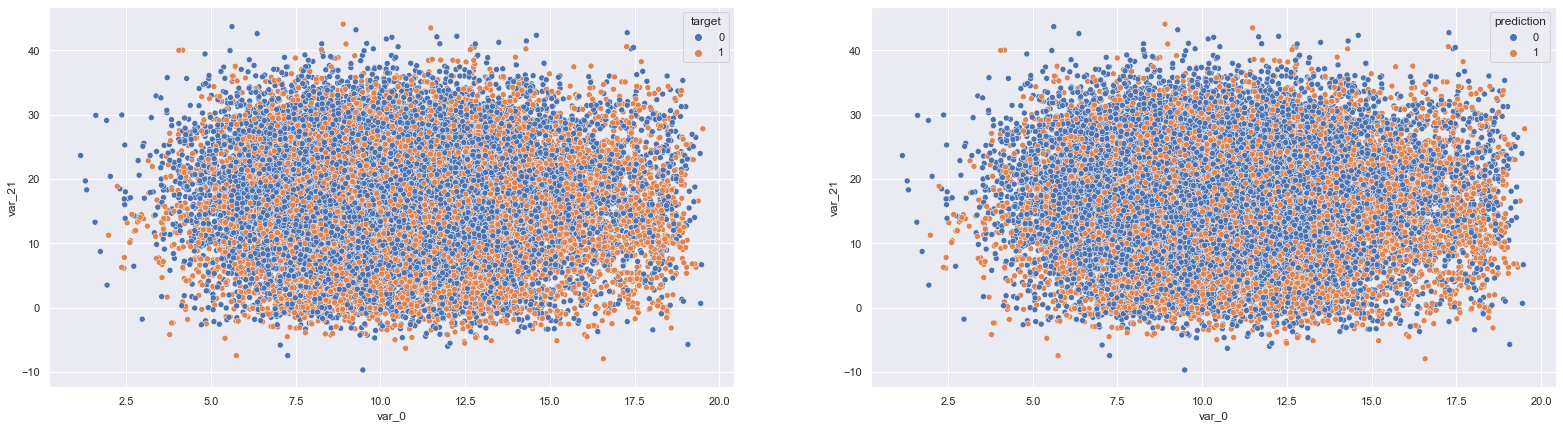

In [36]:
df = validationset.sample(frac = 0.30, replace = False)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(27,7))
sns.scatterplot(ax = axs[0],data = df, x='var_0', y='var_21', hue="target")
sns.scatterplot(ax = axs[1],data = df, x='var_0', y='var_21', hue="prediction")

<b> Validation

In [37]:
predictions = clf.predict(X__val)
predictions_probas = clf.predict_proba(X__val)[:,1]

In [38]:
print('Precision is ' + str(precision_score(y_val.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_val.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_val.values,predictions_probas)))

Precision is 0.5464788732394367
Accuracy is 0.9008777777777778
AUC is 0.7562406699363031


In [39]:
validationset = X__val.assign( target = list(y_val))
validationset = validationset.assign( prediction = list(predictions))

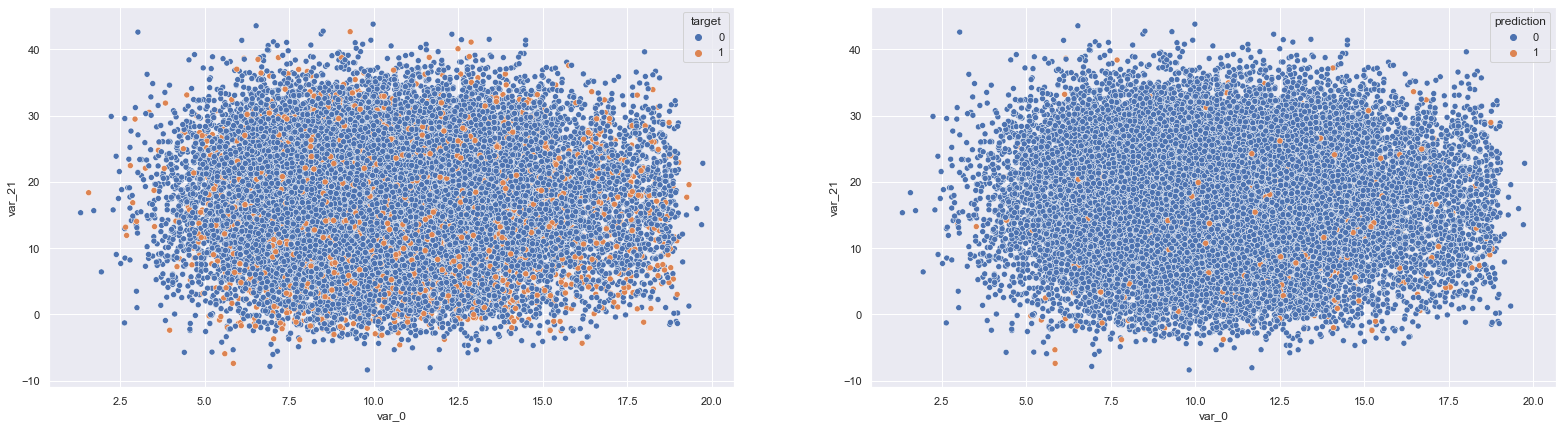

In [40]:
df = validationset.sample(frac = 0.30, replace = False)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(27,7))
sns.scatterplot(ax = axs[0],data = df, x='var_0', y='var_21', hue="target")
sns.scatterplot(ax = axs[1],data = df, x='var_0', y='var_21', hue="prediction")

In [41]:
inputCM = {'TrueVal': y_val.values, 'prediction':predictions}
dfCM = pd.DataFrame(inputCM)
dfCM['lit'] = 1
dfCM.pivot_table(index = 'prediction', columns = 'TrueVal',values = 'lit',aggfunc = 'count')

TrueVal         0     1
prediction             
0           80303  8277
1             644   776

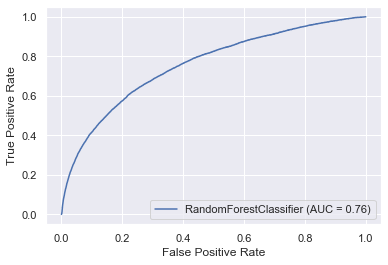

In [42]:
plot_roc_curve(clf, X__val, y_val)

The naive random forest has still some pending work to improve predicting power over the validation set

#### Hyper Parameter tunning

The tunning will be used over a new partition
<br>
creation Training / Val/ Test

In [43]:
split = 0.35
total_rows = len(originaldata)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
testindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))

In [44]:
TrainValSet = originaldata[~originaldata.index.isin(testindexs)].drop(columns = 'TypeSet')
TestSet = originaldata[originaldata.index.isin(testindexs)].drop(columns = 'TypeSet')

In [45]:
split = 0.35
total_rows = len(TrainValSet)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))

In [46]:
TrainSet = TrainValSet[~TrainValSet.index.isin(valindexs)]
dropFalses =list(np.random.choice(list(TrainSet[TrainSet.target == 0 ].index), size=10000, replace=False)) 

In [47]:
TrainSet = pd.concat([TrainSet[~TrainSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])
ValSet = TrainValSet[TrainValSet.index.isin(valindexs)]

In [48]:
TrainSet.shape,ValSet.shape,TestSet.shape

((140403, 22), (29597, 22), (70000, 22))

In [49]:
sampleTrainSet = TrainSet.sample(frac = 0.30, replace = False)
sampleTrainSet.shape

(42121, 22)

In [50]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__val = ValSet.iloc[:,1:]
y_val = ValSet.iloc[:,0]

In [51]:
defaults = {'n_estimators': 100, 'max_depth' : 100, 'min_samples_split': 10, 'min_samples_leaf':10, 'max_features':15 }

In [52]:
def TunningVariable(VariableX, Parameter_list,defaults):
    val_presicion = []
    val_accuracy = []
    val_roc = []
    train_presicion = []
    train_accuracy = []
    train_roc = []

    for varible in Parameter_list:
        defaults[VariableX] = varible
        clf = RandomForestClassifier(n_estimators=defaults['n_estimators'], max_depth = defaults['max_depth'],
                                     min_samples_split = defaults['min_samples_split'] ,
                                     min_samples_leaf = defaults['min_samples_leaf'] ,max_features = defaults['max_features'])
        clf.fit(X__train, y_train)
        ### over train
        predictions = clf.predict(X__train)
        predictions_probas = clf.predict_proba(X__train)[:,1]

        precision = precision_score(y_train.values,predictions)
        accuracy = accuracy_score(y_train.values,predictions)
        roc = roc_auc_score(y_train.values,predictions_probas)

        train_presicion.append(precision)
        train_accuracy.append(accuracy)
        train_roc.append(roc)

        ### over validation

        predictions = clf.predict(X__val)
        predictions_probas = clf.predict_proba(X__val)[:,1]

        precision = precision_score(y_val.values,predictions)
        accuracy = accuracy_score(y_val.values,predictions)
        roc = roc_auc_score(y_val.values,predictions_probas)

        val_presicion.append(precision)
        val_accuracy.append(accuracy)
        val_roc.append(roc)

    return {'val_presicion':val_presicion, 'val_accuracy':val_accuracy,'val_roc':val_roc,
               'train_presicion':train_presicion,'train_accuracy':train_accuracy, 'train_roc':train_roc  }

In [53]:
def plot1_hyperResults(NameVar, Parameter_list, tunning_result):
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(17,5))

    data = {NameVar: Parameter_list , 
            'val_Precision':tunning_result['val_presicion'], 'train_Precision':tunning_result['train_presicion'], 
            'val_Accuracy': tunning_result['val_accuracy'], 'train_Accuracy': tunning_result['train_accuracy'],
            'val_Roc':tunning_result['val_roc'],'train_Roc':tunning_result['train_roc']}

    data = pd.DataFrame(data)
    sns.lineplot(ax=axs[0], data=data, x=NameVar, y="val_Precision",color = 'red')
    sns.lineplot(ax=axs[1],data=data, x=NameVar, y="val_Accuracy",color = 'red')
    sns.lineplot(ax=axs[2],data=data, x=NameVar, y="val_Roc",color = 'red')
    sns.lineplot(ax=axs[0], data=data, x=NameVar, y="train_Precision",color = 'blue')
    sns.lineplot(ax=axs[1],data=data, x=NameVar, y="train_Accuracy",color = 'blue')
    sns.lineplot(ax=axs[2],data=data, x=NameVar, y="train_Roc",color = 'blue')

In [54]:
features_list = [5,7,9,11,15,18,21]
varX = 'max_features'
features_tunning_result = TunningVariable(VariableX = varX, Parameter_list = features_list,defaults = defaults)

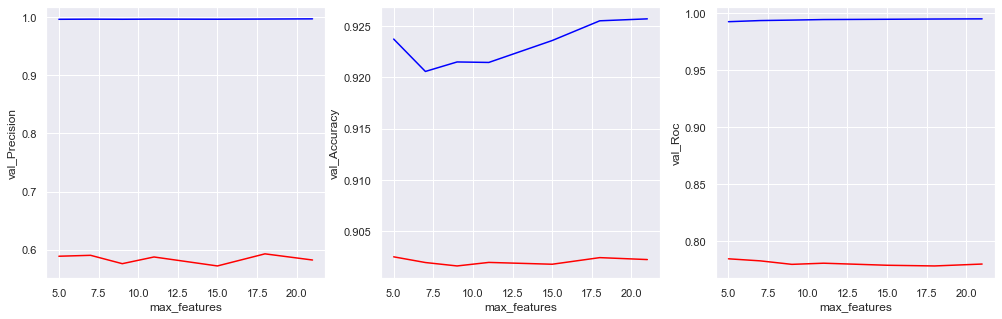

In [55]:
plot1_hyperResults(NameVar = varX, Parameter_list = features_list, tunning_result = features_tunning_result)

In [56]:
min_samples_split_list = [3,5,9,15,21,30,40,50,70,100]
defaults_mod = defaults
defaults_mod['max_features'] = 15
varX = 'min_samples_split'
min_samples_split_tunning_result = TunningVariable(VariableX = varX, Parameter_list = min_samples_split_list,defaults = defaults_mod)

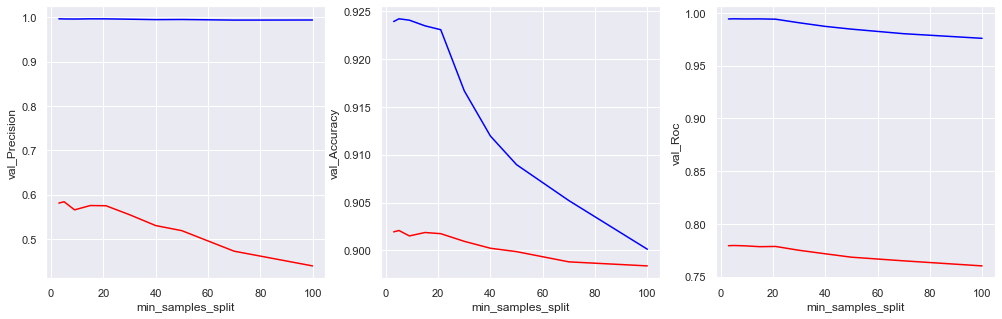

In [57]:
plot1_hyperResults(NameVar = varX, Parameter_list = min_samples_split_list, tunning_result = min_samples_split_tunning_result)

In [58]:
min_samples_leaf_list = [3,5,9,15,21,30,40,50,70,100]
varX = 'min_samples_leaf'
min_samples_leaf_tunning_result = TunningVariable(VariableX = varX, Parameter_list = min_samples_leaf_list,defaults = defaults_mod)

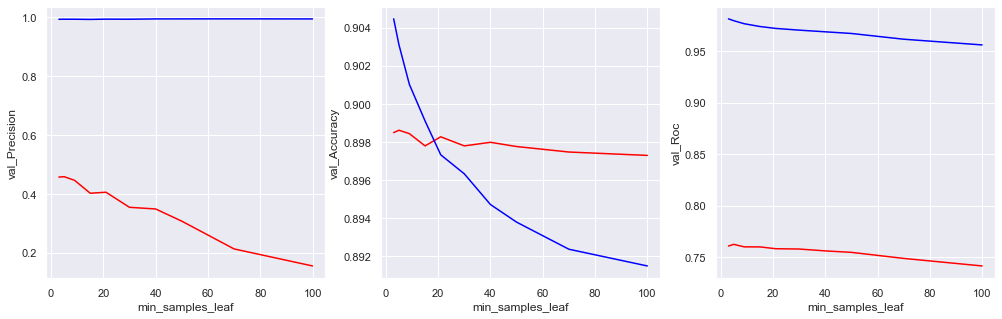

In [59]:
plot1_hyperResults(NameVar = varX, Parameter_list = min_samples_leaf_list, tunning_result = min_samples_leaf_tunning_result)

In [60]:
max_depth_list = [5,10,20,30,40,70,100,150,200,250,300]
defaults_mod['min_samples_split'] = 5
defaults_mod['min_samples_leaf'] = 5
varX = 'max_depth'
max_depth_tunning_result = TunningVariable(VariableX = varX, Parameter_list = max_depth_list,defaults = defaults_mod)

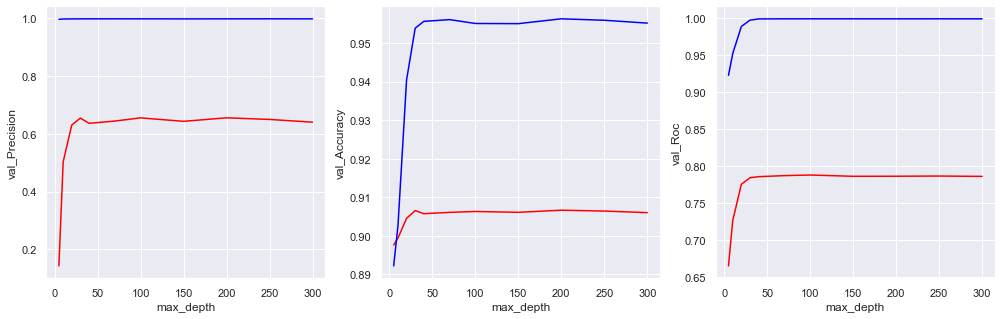

In [61]:
plot1_hyperResults(NameVar = varX, Parameter_list = max_depth_list, tunning_result = max_depth_tunning_result)

In [62]:
n_estimators_list = [5,10,20,30,40,70,100,150,200,250,300]
varX = 'n_estimators'
n_estimators_tunning_result = TunningVariable(VariableX = varX, Parameter_list = n_estimators_list, defaults = defaults_mod)

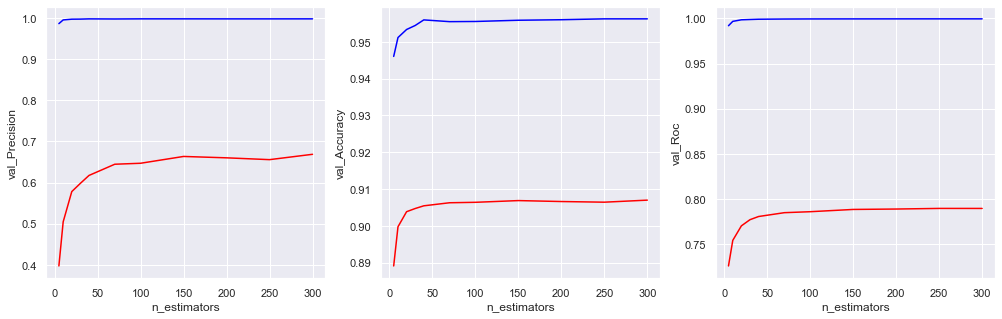

In [63]:
plot1_hyperResults(NameVar = varX, Parameter_list = n_estimators_list, tunning_result = n_estimators_tunning_result)

### Cross Validation

Cross validation and calculation error over validation to check model consistency

In [ ]:
val_presicion = []
val_accuracy = []
val_roc = []

for _ in range(20):
    
    split = 0.35
    total_rows = len(TrainValSet)
    rows_toval = math.ceil(total_rows*split)
    wholeindex = list(range(total_rows))
    valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
    
    TrainSet = TrainValSet[~TrainValSet.index.isin(valindexs)]
    dropFalses =list(np.random.choice(list(TrainSet[TrainSet.target == 0 ].index), size=4000, replace=False)) 
    TrainSet = pd.concat([TrainSet[~TrainSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])
    #TrainSet = pd.concat([TrainSet,augmenteddata.drop(columns = 'TypeSet')])
    
    ValSet = TrainValSet[TrainValSet.index.isin(valindexs)]

    sampleTrainSet = TrainSet.sample(frac = 0.20, replace = False)
    X__train  = sampleTrainSet.iloc[:,1:]
    y_train = sampleTrainSet.iloc[:,0]
    X__val = ValSet.iloc[:,1:]
    y_val = ValSet.iloc[:,0]

    clf = RandomForestClassifier(n_estimators=150, max_depth = 30, min_samples_split = 5 ,min_samples_leaf = 5 ,max_features = 15)
    clf.fit(X__train, y_train)

    predictions = clf.predict(X__val)
    predictions_probas = clf.predict_proba(X__val)[:,1]

    precision = precision_score(y_val.values,predictions)
    accuracy = accuracy_score(y_val.values,predictions)
    roc = roc_auc_score(y_val.values,predictions_probas)

    val_presicion.append(precision)
    val_accuracy.append(accuracy)
    val_roc.append(roc)

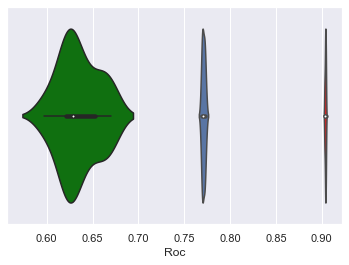

In [67]:
val_roc

data = {'Precision':val_presicion, 'Accuracy': val_accuracy, 'Roc':val_roc} 
data = pd.DataFrame(data)
sns.violinplot(x=data.Precision,color = 'green')
sns.violinplot(x=data.Accuracy, color = 'red')
sns.violinplot(x=data.Roc)
#sns.lineplot(ax=axs[1],data=data, x="Depth", y="Accuracy")
#sns.lineplot(ax=axs[2],data=data, x="Depth", y="Roc")

key porints:
* the mean accuracy has improved in average and using 20 fold crs validation
* though, accuracy and auc aer very stable
* the sampling strategy be carefull

<b> Validation and testing model

In [71]:
dropFalses =list(np.random.choice(list(TrainValSet[TrainValSet.target == 0 ].index), size=14000, replace=False)) 
TrainSet = pd.concat([TrainValSet[~TrainValSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])

In [72]:
sampleTrainSet = TrainSet.sample(frac = 0.70, replace = False)

In [73]:
TrainSet.shape, sampleTrainSet.shape

((166000, 22), (116200, 22))

In [79]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__test = TestSet.iloc[:,1:]
y_test = TestSet.iloc[:,0]

In [76]:
clf = RandomForestClassifier(n_estimators=150, max_depth = 30, min_samples_split = 5 ,min_samples_leaf = 5 ,max_features = 15)
clf.fit(X__train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
predictions = clf.predict(X__test)
predictions_probas = clf.predict_proba(X__test)[:,1]

In [81]:
print('Precision is ' + str(precision_score(y_test.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_test.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_test.values,predictions_probas)))

Precision is 0.5792349726775956
Accuracy is 0.9010857142857143
AUC is 0.7647020842638935


Saving model

In [84]:
gatooooo
filename = 'My Random Forest.sav'
joblib.dump(clf, filename)

['My Random Forest.sav']

Key Ideas:
* Using parameter tunning and cross validation  it is found that the Random Forest improves a little bit

### Training Gradient Boosting Machine

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

<b> verifying the simulations

In [5]:
simulations = pd.read_csv('simulations.csv').sample(frac = 0.50, replace = False)
simulations.head()

ID_code  target      var_0     var_1      var_2     var_3      var_4  \
53205    simu       1  12.331479 -0.339241   9.585207  6.683775  10.565989   
9186     simu       1  10.609329  0.588213  10.214759  9.238880   8.068571   
29071    simu       1   7.637568 -5.306180   8.865812  5.161256  13.034371   
20839    simu       1   7.152162 -3.303815  14.466574  8.759890   8.233511   
80820    simu       1   7.409726  2.673172  14.857206  9.134352  13.704372   

           var_5     var_6      var_7  ...   var_190    var_191   var_192  \
53205   1.181382  4.711333  21.118347  ...  1.176125   8.042957  0.409461   
9186   -3.579274  3.654140  21.150498  ...  3.931163   9.191403  1.355791   
29071 -15.595463  4.349423  17.059358  ... -0.039825  10.035056  4.163802   
20839  -9.953493  7.064727  16.030475  ... -0.290131   5.919064  0.270794   
80820 -21.034160  5.485827  15.128940  ...  3.260364   4.413162 -0.110509   

        var_193    var_194   var_195   var_196   var_197    var_198    var_199  
53205  6.081572  10.708206 -1.485076  5.885313  8.427497  15.653428 -13.970579  
9186   7.668146  22.107159  0.699767  4.330028  7.269886  10.881654   3.035162  
29071  4.306084  17.721095 -0.358425  3.962376  7.049182  15.362445 -27.667449  
20839  6.782518  15.637654  0.127441 -0.726355  9.514461  17.740362 -17.021210  
80820  4.514777  21.791439  1.565828  5.810050  8.038995  15.124590 -16.196744  

[5 rows x 202 columns]

In [6]:
simulations.shape

(50000, 202)

In [7]:
train['TypeSet'] = 'Original'
simulations['TypeSet'] = 'Augmented'
balancedtrain = pd.concat([train,simulations])

In [8]:
df = balancedtrain.pivot_table(index = 'target', aggfunc = 'count')[['ID_code']].reset_index()
df['total'] = df.ID_code.sum()
df = df.assign(percent = df.ID_code/df.total)

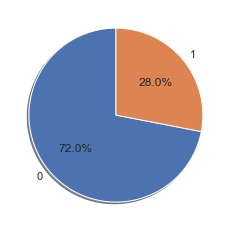

In [9]:
fig1, ax1 = plt.subplots()
ax1.pie(df.percent, labels = df.target , autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

<b> Model Explo

In [10]:
embeded_rf_feature = ['var_0','var_2','var_6', 'var_12', 'var_21', 'var_22', 'var_26', 'var_44','var_53', 'var_68', 'var_76', 'var_80', 'var_81', 'var_91',
 'var_99','var_108', 'var_109', 'var_110','var_139', 'var_146', 'var_148']

In [11]:
len(embeded_rf_feature)

21

In [12]:
generaldata = balancedtrain[['target']+ embeded_rf_feature + ['TypeSet']]

In [13]:
generaldata.TypeSet.unique()

array(['Original', 'Augmented'], dtype=object)

In [14]:
originaldata = generaldata[generaldata.TypeSet == 'Original']
augmenteddata = generaldata[generaldata.TypeSet == 'Augmented']

In [15]:
%%time
split = 0.45
total_rows = len(originaldata)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
#trainindexs = [x for x in wholeindex if x not in valindexs]

Wall time: 31.9 ms


In [16]:
trainSet = originaldata[~originaldata.index.isin(valindexs)]
dropFalses =list(np.random.choice(list(trainSet[trainSet.target == 0 ].index), size=10000, replace=False)) 

In [17]:
trainSet = pd.concat([trainSet[~trainSet.index.isin(dropFalses)],augmenteddata]).drop(columns = 'TypeSet')
validationSet = originaldata[originaldata.index.isin(valindexs)].drop(columns = 'TypeSet')

In [18]:
trainSet.shape,validationSet.shape

((150000, 22), (90000, 22))

In [19]:
sampleTrainSet = trainSet.sample(frac = 0.60, replace = False)
sampleTrainSet.shape

(90000, 22)

In [20]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__val = validationSet.iloc[:,1:]
y_val = validationSet.iloc[:,0]

In [21]:
sampleTrainSet.groupby('target').count()

var_0  var_2  var_6  var_12  var_21  var_22  var_26  var_44  var_53  \
target                                                                        
0       53341  53341  53341   53341   53341   53341   53341   53341   53341   
1       36659  36659  36659   36659   36659   36659   36659   36659   36659   

        var_68  ...  var_80  var_81  var_91  var_99  var_108  var_109  \
target          ...                                                     
0        53341  ...   53341   53341   53341   53341    53341    53341   
1        36659  ...   36659   36659   36659   36659    36659    36659   

        var_110  var_139  var_146  var_148  
target                                      
0         53341    53341    53341    53341  
1         36659    36659    36659    36659  

[2 rows x 21 columns]

In [24]:
gbc = GradientBoostingClassifier(learning_rate=0.25, n_estimators = 150, subsample = 0.75 ,min_samples_split = 10 ,min_samples_leaf = 10, max_features = 21)
gbc.fit(X__train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=3,
                           max_features=21, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.75, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
predictions = gbc.predict(X__train)
predictions_probas = gbc.predict_proba(X__train)[:,1]

In [26]:
print('Precision is ' + str(precision_score(y_train.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_train.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_train.values,predictions_probas)))

Precision is 0.9682670174284774
Accuracy is 0.9091222222222223
AUC is 0.9502653444793476


In [27]:
validationset = X__train.assign( target = list(y_train))
validationset = validationset.assign( prediction = list(predictions))

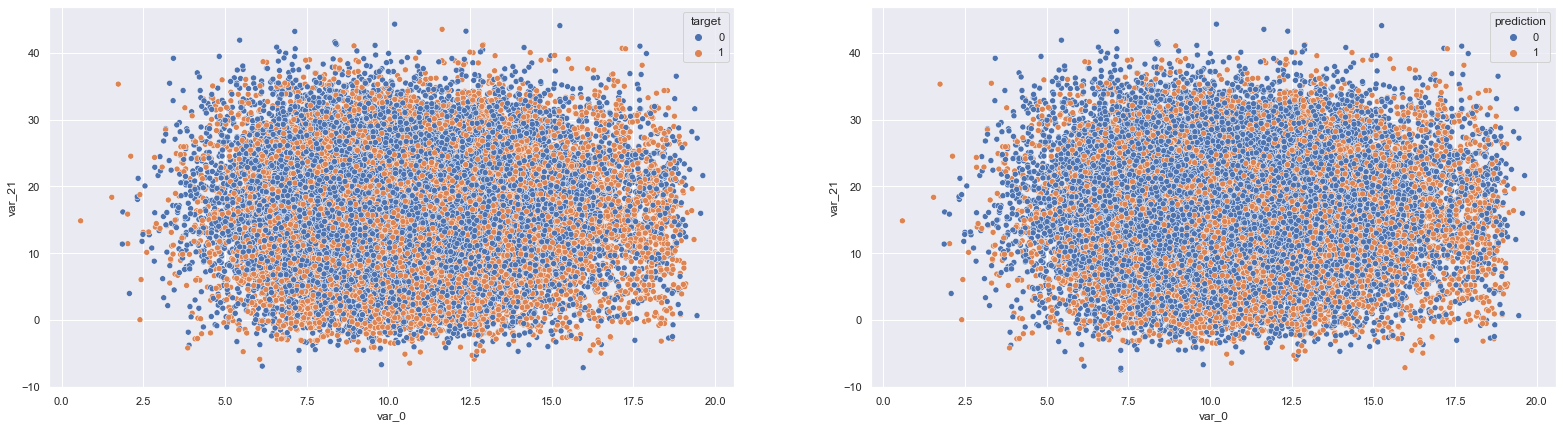

In [28]:
df = validationset.sample(frac = 0.30, replace = False)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(27,7))
sns.scatterplot(ax = axs[0],data = df, x='var_0', y='var_21', hue="target")
sns.scatterplot(ax = axs[1],data = df, x='var_0', y='var_21', hue="prediction")

<b> Validation

In [29]:
predictions = gbc.predict(X__val)
predictions_probas = gbc.predict_proba(X__val)[:,1]

In [30]:
print('Precision is ' + str(precision_score(y_val.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_val.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_val.values,predictions_probas)))

Precision is 0.4445385266723116
Accuracy is 0.8951888888888889
AUC is 0.7526356277217635


In [31]:
validationset = X__val.assign( target = list(y_val))
validationset = validationset.assign( prediction = list(predictions))

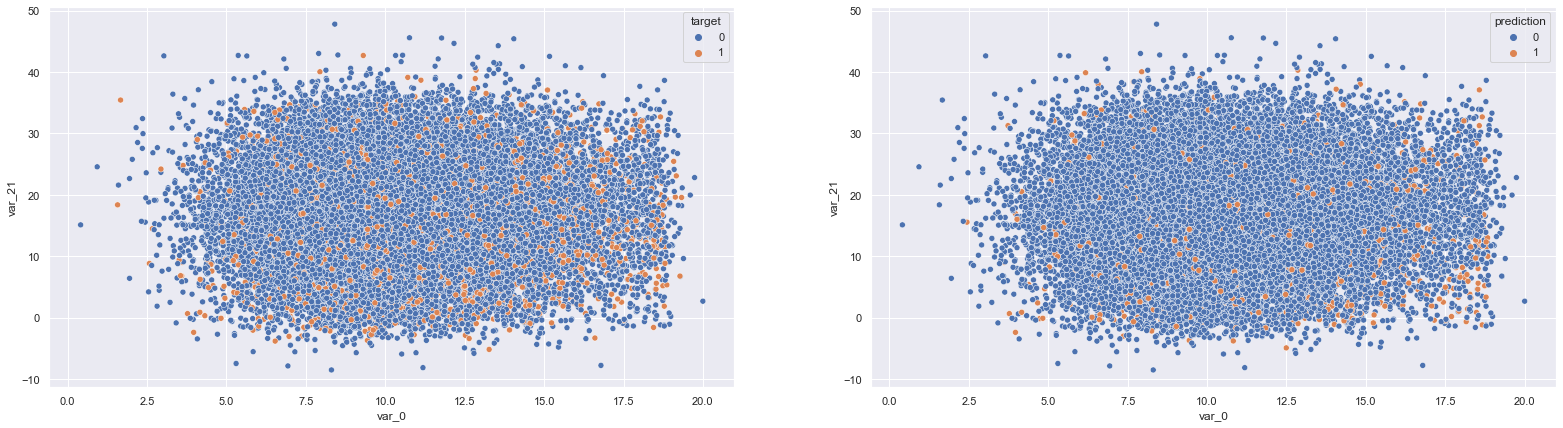

In [32]:
df = validationset.sample(frac = 0.30, replace = False)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(27,7))
sns.scatterplot(ax = axs[0],data = df, x='var_0', y='var_21', hue="target")
sns.scatterplot(ax = axs[1],data = df, x='var_0', y='var_21', hue="prediction")

In [33]:
inputCM = {'TrueVal': y_val.values, 'prediction':predictions}
dfCM = pd.DataFrame(inputCM)
dfCM['lit'] = 1
dfCM.pivot_table(index = 'prediction', columns = 'TrueVal',values = 'lit',aggfunc = 'count')

TrueVal         0     1
prediction             
0           78992  7465
1            1968  1575

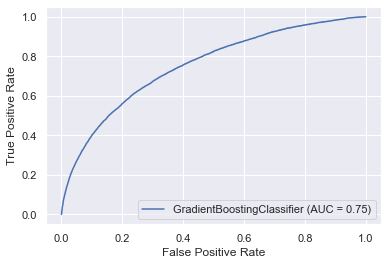

In [34]:
plot_roc_curve(gbc, X__val, y_val)

#### Hyper Parameter tunning

The tunning will be used over a new partition
<br>
creation Training / Val/ Test

In [35]:
split = 0.35
total_rows = len(originaldata)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
testindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))

In [36]:
TrainValSet = originaldata[~originaldata.index.isin(testindexs)].drop(columns = 'TypeSet')
TestSet = originaldata[originaldata.index.isin(testindexs)].drop(columns = 'TypeSet')

In [37]:
split = 0.35
total_rows = len(TrainValSet)
rows_toval = math.ceil(total_rows*split)
wholeindex = list(range(total_rows))
valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))

In [38]:
TrainSet = TrainValSet[~TrainValSet.index.isin(valindexs)]
dropFalses =list(np.random.choice(list(TrainSet[TrainSet.target == 0 ].index), size=10000, replace=False)) 

In [39]:
TrainSet = pd.concat([TrainSet[~TrainSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])
ValSet = TrainValSet[TrainValSet.index.isin(valindexs)]

In [40]:
TrainSet.shape,ValSet.shape,TestSet.shape

((140303, 22), (29697, 22), (70000, 22))

In [41]:
sampleTrainSet = TrainSet.sample(frac = 0.30, replace = False)
sampleTrainSet.shape

(42091, 22)

In [42]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__val = ValSet.iloc[:,1:]
y_val = ValSet.iloc[:,0]

In [43]:
defaults = {'learning_rate': 0.25 ,'n_estimators': 150 ,'subsample': 0.75 ,'min_samples_split': 10,'min_samples_leaf': 10,'max_features': 21}

In [44]:
def TunningVariable(VariableX, Parameter_list,defaults):
    val_presicion = []
    val_accuracy = []
    val_roc = []
    train_presicion = []
    train_accuracy = []
    train_roc = []

    for varible in Parameter_list:
        defaults[VariableX] = varible
        
        gbc = GradientBoostingClassifier(learning_rate=defaults['learning_rate'], n_estimators = defaults['n_estimators'], 
                                         subsample = defaults['subsample'] ,min_samples_split = defaults['min_samples_split'] ,
                                         min_samples_leaf = defaults['min_samples_leaf'], max_features = defaults['max_features'])

        gbc.fit(X__train, y_train)
        ### over train
        predictions = gbc.predict(X__train)
        predictions_probas = gbc.predict_proba(X__train)[:,1]

        precision = precision_score(y_train.values,predictions)
        accuracy = accuracy_score(y_train.values,predictions)
        roc = roc_auc_score(y_train.values,predictions_probas)

        train_presicion.append(precision)
        train_accuracy.append(accuracy)
        train_roc.append(roc)

        ### over validation

        predictions = gbc.predict(X__val)
        predictions_probas = gbc.predict_proba(X__val)[:,1]

        precision = precision_score(y_val.values,predictions)
        accuracy = accuracy_score(y_val.values,predictions)
        roc = roc_auc_score(y_val.values,predictions_probas)

        val_presicion.append(precision)
        val_accuracy.append(accuracy)
        val_roc.append(roc)

    return {'val_presicion':val_presicion, 'val_accuracy':val_accuracy,'val_roc':val_roc,
               'train_presicion':train_presicion,'train_accuracy':train_accuracy, 'train_roc':train_roc  }

In [45]:
def plot1_hyperResults(NameVar, Parameter_list, tunning_result):
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(17,5))

    data = {NameVar: Parameter_list , 
            'val_Precision':tunning_result['val_presicion'], 'train_Precision':tunning_result['train_presicion'], 
            'val_Accuracy': tunning_result['val_accuracy'], 'train_Accuracy': tunning_result['train_accuracy'],
            'val_Roc':tunning_result['val_roc'],'train_Roc':tunning_result['train_roc']}

    data = pd.DataFrame(data)
    sns.lineplot(ax=axs[0], data=data, x=NameVar, y="val_Precision",color = 'red')
    sns.lineplot(ax=axs[1],data=data, x=NameVar, y="val_Accuracy",color = 'red')
    sns.lineplot(ax=axs[2],data=data, x=NameVar, y="val_Roc",color = 'red')
    sns.lineplot(ax=axs[0], data=data, x=NameVar, y="train_Precision",color = 'blue')
    sns.lineplot(ax=axs[1],data=data, x=NameVar, y="train_Accuracy",color = 'blue')
    sns.lineplot(ax=axs[2],data=data, x=NameVar, y="train_Roc",color = 'blue')

In [46]:
min_samples_leaf_list = [3,5,9,15,21,30,40,50,70,100]
varX = 'min_samples_leaf'
min_samples_leaf_result = TunningVariable(VariableX = varX, Parameter_list = min_samples_leaf_list,defaults = defaults)

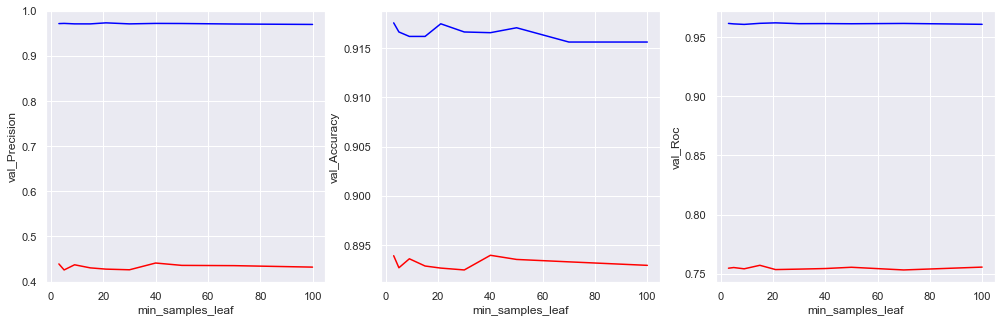

In [48]:
plot1_hyperResults(NameVar = varX, Parameter_list = min_samples_leaf_list, tunning_result = min_samples_leaf_result)

In [51]:
min_samples_split_list = [3,5,9,15,21,30,40,50,70,100]
varX = 'min_samples_split'
min_samples_split_result = TunningVariable(VariableX = varX, Parameter_list = min_samples_split_list,defaults = defaults)

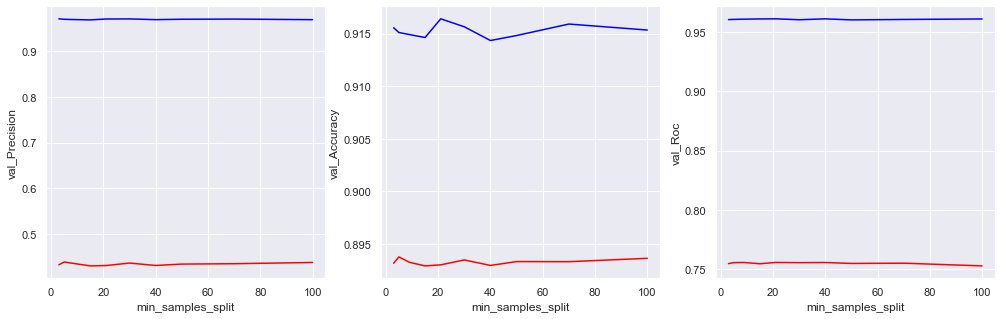

In [52]:
plot1_hyperResults(NameVar = varX, Parameter_list = min_samples_split_list, tunning_result = min_samples_split_result)

In [53]:
features_list = [5,7,9,11,15,18,21]
defaults_mod = defaults
defaults_mod['min_samples_leaf'] = 40
defaults_mod['min_samples_split'] = 30
varX = 'max_features'
features_result = TunningVariable(VariableX = varX, Parameter_list = features_list,defaults = defaults_mod)

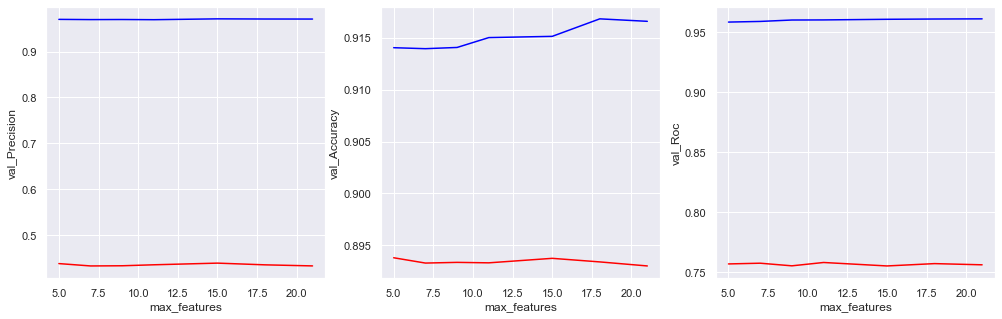

In [55]:
plot1_hyperResults(NameVar = varX, Parameter_list = features_list, tunning_result = features_result)

In [56]:
subsample_list = [1.0 ,0.90 ,0.80 ,0.70 ,0.6 ,0.5 ]
defaults_mod['max_feature'] = 15
varX = 'subsample'
subsample_result = TunningVariable(VariableX = varX, Parameter_list = subsample_list,defaults = defaults_mod)

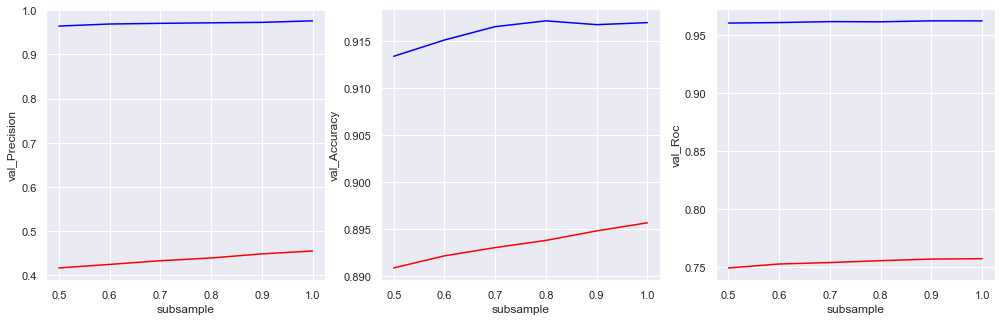

In [57]:
plot1_hyperResults(NameVar = varX, Parameter_list = subsample_list, tunning_result = subsample_result)

In [58]:
n_estimators_list = [5,10,20,30,40,70,100,150,200,250,300]
varX = 'n_estimators'
n_estimators_result = TunningVariable(VariableX = varX, Parameter_list = n_estimators_list, defaults = defaults_mod)

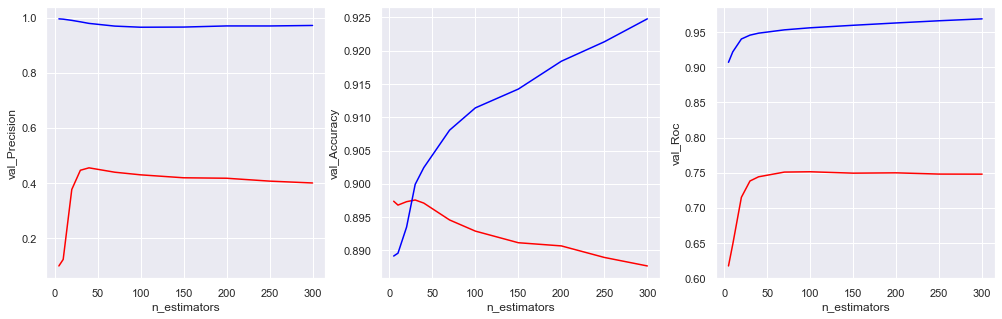

In [59]:
plot1_hyperResults(NameVar = varX, Parameter_list = n_estimators_list, tunning_result = n_estimators_result)

In [60]:
learning_rate_list = [0.35,0.30,0.25,0.20,0.15,0.10,0.05]
varX = 'learning_rate'
learning_rate_result = TunningVariable(VariableX = varX, Parameter_list = learning_rate_list, defaults = defaults_mod)

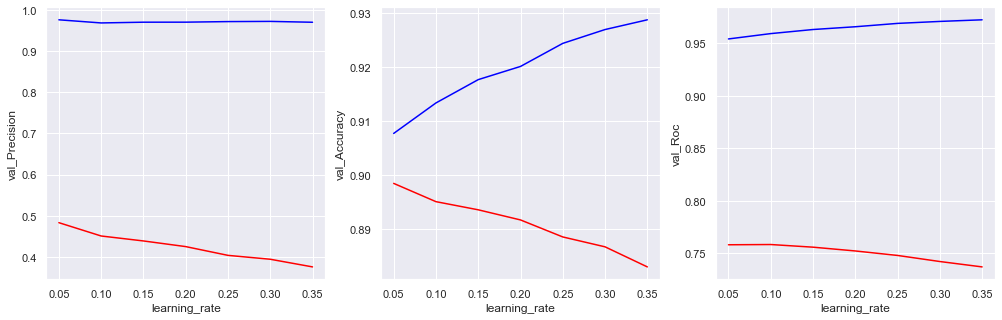

In [61]:
plot1_hyperResults(NameVar = varX, Parameter_list = learning_rate_list, tunning_result = learning_rate_result)

In [74]:
defaults_mod

{'learning_rate': 0.05,
 'n_estimators': 300,
 'subsample': 0.5,
 'min_samples_split': 30,
 'min_samples_leaf': 40,
 'max_features': 21,
 'max_feature': 15}

### Cross Validation

Cross validation and calculation error over validation to check model consistency

In [79]:
val_presicion = []
val_accuracy = []
val_roc = []

for _ in range(20):
    
    split = 0.35
    total_rows = len(TrainValSet)
    rows_toval = math.ceil(total_rows*split)
    wholeindex = list(range(total_rows))
    valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
    
    TrainSet = TrainValSet[~TrainValSet.index.isin(valindexs)]
    dropFalses =list(np.random.choice(list(TrainSet[TrainSet.target == 0 ].index), size=4000, replace=False)) 
    TrainSet = pd.concat([TrainSet[~TrainSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])
    #TrainSet = pd.concat([TrainSet,augmenteddata.drop(columns = 'TypeSet')])
    
    ValSet = TrainValSet[TrainValSet.index.isin(valindexs)]

    sampleTrainSet = TrainSet.sample(frac = 0.20, replace = False)
    X__train  = sampleTrainSet.iloc[:,1:]
    y_train = sampleTrainSet.iloc[:,0]
    X__val = ValSet.iloc[:,1:]
    y_val = ValSet.iloc[:,0]

    gbc = GradientBoostingClassifier(learning_rate= 0.05 , n_estimators = 300, subsample = 1.0 ,min_samples_split = 30 ,
                                         min_samples_leaf = 40, max_features = 15)
    gbc.fit(X__train, y_train)

    predictions = gbc.predict(X__val)
    predictions_probas = gbc.predict_proba(X__val)[:,1]

    precision = precision_score(y_val.values,predictions)
    accuracy = accuracy_score(y_val.values,predictions)
    roc = roc_auc_score(y_val.values,predictions_probas)

    val_presicion.append(precision)
    val_accuracy.append(accuracy)
    val_roc.append(roc)

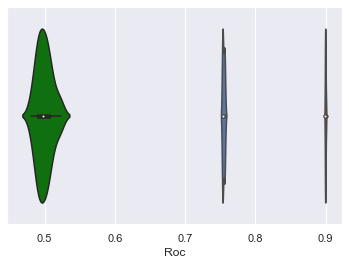

In [80]:
data = {'Precision':val_presicion, 'Accuracy': val_accuracy, 'Roc':val_roc} 
data = pd.DataFrame(data)
sns.violinplot(x=data.Precision,color = 'green')
sns.violinplot(x=data.Accuracy, color = 'red')
sns.violinplot(x=data.Roc)
#sns.lineplot(ax=axs[1],data=data, x="Depth", y="Accuracy")
#sns.lineplot(ax=axs[2],data=data, x="Depth", y="Roc")

key porints:
* the mean accuracy has improved in average and using 20 fold crs validation
* though, accuracy and auc aer very stable
* the sampling strategy be carefull

<b> Validation and testing model

In [81]:
dropFalses =list(np.random.choice(list(TrainValSet[TrainValSet.target == 0 ].index), size=14000, replace=False)) 
TrainSet = pd.concat([TrainValSet[~TrainValSet.index.isin(dropFalses)],augmenteddata.drop(columns = 'TypeSet')])

In [82]:
sampleTrainSet = TrainSet.sample(frac = 0.70, replace = False)

In [83]:
TrainSet.shape, sampleTrainSet.shape

((166000, 22), (116200, 22))

In [84]:
X__train  = sampleTrainSet.iloc[:,1:]
y_train = sampleTrainSet.iloc[:,0]
X__test = TestSet.iloc[:,1:]
y_test = TestSet.iloc[:,0]

In [85]:
gbc = GradientBoostingClassifier(learning_rate= 0.05 , n_estimators = 300, subsample = 1.0 ,min_samples_split = 30 ,
                                         min_samples_leaf = 40, max_features = 15)
gbc.fit(X__train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=15, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=40, min_samples_split=30,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [86]:
predictions = gbc.predict(X__test)
predictions_probas = gbc.predict_proba(X__test)[:,1]

In [87]:
print('Precision is ' + str(precision_score(y_test.values,predictions)))
print('Accuracy is ' + str(accuracy_score(y_test.values,predictions)))
print('AUC is ' + str(roc_auc_score(y_test.values,predictions_probas)))

Precision is 0.5107913669064749
Accuracy is 0.8985
AUC is 0.753392905265067


In [88]:
gatooooo
filename = 'My Gradient Boosting Machine.sav'
joblib.dump(gbc, filename)

['My Gradient Boosting Machine.sav']

Key ideas:
* Using parameter tunning the Gradient Boost improves a lot

General Idea:
* The Random forest is a little bit better than the GradientBoost
* The scores here below are are mede on indepent validation split for each machine
* then a joint test over the training data set to determine the winner

### Joint Testing

In [24]:
simulations = pd.read_csv('simulations.csv').sample(frac = 0.50, replace = False)

In [25]:
simulations.shape

(50000, 202)

In [26]:
train['TypeSet'] = 'Original'
simulations['TypeSet'] = 'Augmented'
balancedtrain = pd.concat([train,simulations])

In [27]:
embeded_rf_feature = ['var_0','var_2','var_6', 'var_12', 'var_21', 'var_22', 'var_26', 'var_44','var_53', 'var_68', 'var_76', 'var_80', 'var_81', 'var_91',
 'var_99','var_108', 'var_109', 'var_110','var_139', 'var_146', 'var_148']

In [28]:
generaldata = balancedtrain[['target']+ embeded_rf_feature + ['TypeSet']]

In [29]:
generaldata.TypeSet.unique()

array(['Original', 'Augmented'], dtype=object)

In [35]:
originaldata = generaldata[generaldata.TypeSet == 'Original'].drop(columns = 'TypeSet')

In [36]:
GBM = joblib.load('My Gradient Boosting Machine.sav')
RFM = joblib.load('My Random Forest.sav')

In [37]:
GBM_val_presicion = []
GBM_val_accuracy = []
GBM_val_roc = []
RFM_val_presicion = []
RFM_val_accuracy = []
RFM_val_roc = []

for _ in range(20):
    
    split = 0.35
    total_rows = len(originaldata)
    rows_toval = math.ceil(total_rows*split)
    wholeindex = list(range(total_rows))
    valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
    
    ValSet = originaldata[originaldata.index.isin(valindexs)]

    X__val = ValSet.iloc[:,1:]
    y_val = ValSet.iloc[:,0]
    ### GBM
    predictions = GBM.predict(X__val)
    predictions_probas = GBM.predict_proba(X__val)[:,1]

    precision = precision_score(y_val.values,predictions)
    accuracy = accuracy_score(y_val.values,predictions)
    roc = roc_auc_score(y_val.values,predictions_probas)

    GBM_val_presicion.append(precision)
    GBM_val_accuracy.append(accuracy)
    GBM_val_roc.append(roc)
    ###RFM
    predictions = RFM.predict(X__val)
    predictions_probas = RFM.predict_proba(X__val)[:,1]

    precision = precision_score(y_val.values,predictions)
    accuracy = accuracy_score(y_val.values,predictions)
    roc = roc_auc_score(y_val.values,predictions_probas)

    RFM_val_presicion.append(precision)
    RFM_val_accuracy.append(accuracy)
    RFM_val_roc.append(roc)

In [52]:
Machine = ['RFM'] * len(GBM_val_presicion) + ['GBM'] * len(GBM_val_presicion) 
Precisions = RFM_val_presicion + GBM_val_presicion
Accuracies =RFM_val_accuracy + GBM_val_accuracy
Rocs = RFM_val_roc + GBM_val_roc

data = {'Machine' : Machine, 'Precision': Precisions, 'Accuracy': Accuracies, 'ROC': Rocs} 
scoresDF = pd.DataFrame(data)
scoresDF = scoresDF.melt( id_vars=['Machine'], value_vars=['Precision','Accuracy','ROC'],var_name='TypeScore', value_name='Value')

In [53]:
scoresDF.head()

Machine  TypeScore     Value
0     RFM  Precision  0.875853
1     RFM  Precision  0.877400
2     RFM  Precision  0.874838
3     RFM  Precision  0.882018
4     RFM  Precision  0.878989

[Text(0, 0.5, '')]

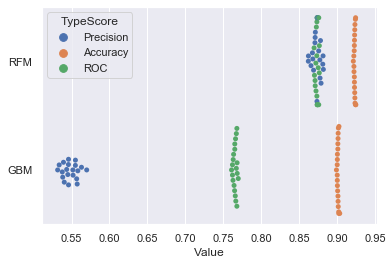

In [54]:
ax = sns.swarmplot(data=scoresDF, x="Value", y="Machine", hue="TypeScore")
ax.set(ylabel="")

My random forest Machine is by far the best

predictions over definiteve test

In [61]:
testdf = test[embeded_rf_feature]
testdf.head()

var_0    var_2   var_6   var_12   var_21  var_22   var_26   var_44  \
0  11.0656  12.9536  5.8493  13.9696  18.8064  1.5899  -9.4902  13.3680   
1   8.5304  11.3047  6.0196  14.1129   3.1389  5.2578  -5.2341   2.1782   
2   5.4827  10.1407  4.8950  13.6751  12.3696  4.7473 -15.4246   8.3565   
3   8.5374  12.0220  4.9397  14.0526  12.5527  2.9707   1.0061   6.6917   
4  11.7058  14.1295  6.8595  14.1013  16.3059  6.7954   8.6228  18.9670   

   var_53  var_68  ...   var_80   var_81  var_91  var_99  var_108  var_109  \
0  7.3213  5.0125  ...   9.4883  16.9060  7.0834  1.8585  14.0176  15.0763   
1  6.8481  5.0306  ...   1.9772  14.0406  7.1848 -1.4166  13.7963  17.7261   
2  5.6510  5.0093  ...  16.1691  14.3299  7.0194  1.7818  14.0232  19.4604   
3  6.2536  5.0087  ...  17.5941  15.4375  6.9174  2.6165  14.2000  23.0368   
4  5.6794  5.0267  ...  11.8133  16.7661  7.0197  0.1148  14.2212  16.0638   

   var_110  var_139  var_146  var_148  
0   3.7662  -2.5502  11.6793   4.1017  
1   1.7375   6.7530   8.7644   4.1240  
2   8.6896  -6.0452  11.6749   4.2600  
3  10.3445  12.7898   8.6963   3.8265  
4   6.3933  11.7989  12.9327   4.2135  

[5 rows x 21 columns]

In [62]:
predictions = GBM.predict(testdf)

In [63]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
test['target'] = predictions

In [76]:
testexp = test[['ID_code','target']]

In [78]:
testexp.groupby('target').count()

ID_code
target         
0        196506
1          3494

In [79]:
testexp.to_csv('Predictions_v1.csv',index=False)